# Music genre discovery and audio feature clustering
## Unsupervised Learning final project

- Discover latent music genres/subgenres from Spotify audio features
- Apply multiple unsupervised learning techniques
- Build foundation of music recommendation system
- Visualize and interpret discovered music clusters

Dataset: [Spotify Tracks Dataset (125 genres)](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

Author: Rylan Turner

Date: June 2025

## Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
import umap

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Setup complete")

Setup complete


## Data loading and initial exploration

In [2]:
def load_spotify_data():
    """
    Load Spotify tracks dataset
    """
    try:
        df = pd.read_csv('spotify_tracks.csv')
        print(f"Dataset loaded successfully")
        print(f"Shape: {df.shape[0]:,} tracks × {df.shape[1]} features")
        return df
    except FileNotFoundError:
        print("Dataset not found or other error has occured")
        return None

df = load_spotify_data()

if df is not None:
    print("DATASET OVERVIEW")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB")
    
    print("\nColumn Information:")
    print(df.info())
    
    print("\nFirst 5 rows:")
    display(df.head())
    
    print("\nBasic Statistics:")
    display(df.describe())

Dataset loaded successfully
Shape: 114,000 tracks × 21 features
DATASET OVERVIEW
Dataset shape: (114000, 21)
Memory usage: 17.5 MB

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness 

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic


Basic Statistics:


Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

## Data cleaning and preprocessing

In [3]:
def clean_spotify_data(df):
    """
    Clean and preprocess Spotify dataset
    """
    print("Starting data cleaning...")
    
    df_clean = df.copy()
    
    missing_vals = df_clean.isnull().sum()
    if missing_vals.sum() > 0:
        print("Missing values found:")
        print(missing_vals[missing_vals > 0])
        
        df_clean = df_clean.dropna()
        print(f"Dropped rows with missing values. New shape: {df_clean.shape}")
    else:
        print("No missing values found")
    
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = initial_rows - len(df_clean)
    if duplicates_removed > 0:
        print(f"Removed {duplicates_removed:,} duplicate rows")
    
    # Identify audio feature columns
    audio_features = [
        'danceability', 'energy', 'loudness', 'speechiness', 
        'acousticness', 'instrumentalness', 'liveness', 'valence', 
        'tempo', 'duration_ms', 'time_signature'
    ]
    
    # Check which audio features are present
    available_features = [col for col in audio_features if col in df_clean.columns]
    print(f"Available audio features: {available_features}")
    
    # Outlier detection using IQR method
    print("\nOutlier Detection:")
    for feature in available_features:
        if feature in df_clean.columns:
            Q1 = df_clean[feature].quantile(0.25)
            Q3 = df_clean[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = ((df_clean[feature] < lower_bound) | 
                       (df_clean[feature] > upper_bound)).sum()
            outlier_pct = (outliers / len(df_clean)) * 100
            print(f"{feature}: {outliers:,} outliers ({outlier_pct:.1f}%)")
    
    print(f"\nData cleaning complete. Final shape: {df_clean.shape}")
    return df_clean, available_features

if df is not None:
    df_clean, audio_features = clean_spotify_data(df)


Starting data cleaning...
Missing values found:
artists       1
album_name    1
track_name    1
dtype: int64
Dropped rows with missing values. New shape: (113999, 21)
Available audio features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

Outlier Detection:
danceability: 620 outliers (0.5%)
energy: 0 outliers (0.0%)
loudness: 6,173 outliers (5.4%)
speechiness: 13,211 outliers (11.6%)
acousticness: 0 outliers (0.0%)
instrumentalness: 25,246 outliers (22.1%)
liveness: 8,642 outliers (7.6%)
valence: 0 outliers (0.0%)
tempo: 617 outliers (0.5%)
duration_ms: 5,616 outliers (4.9%)
time_signature: 12,157 outliers (10.7%)

Data cleaning complete. Final shape: (113999, 21)


## Exploratory data analysis

Starting exploratory data analysis...


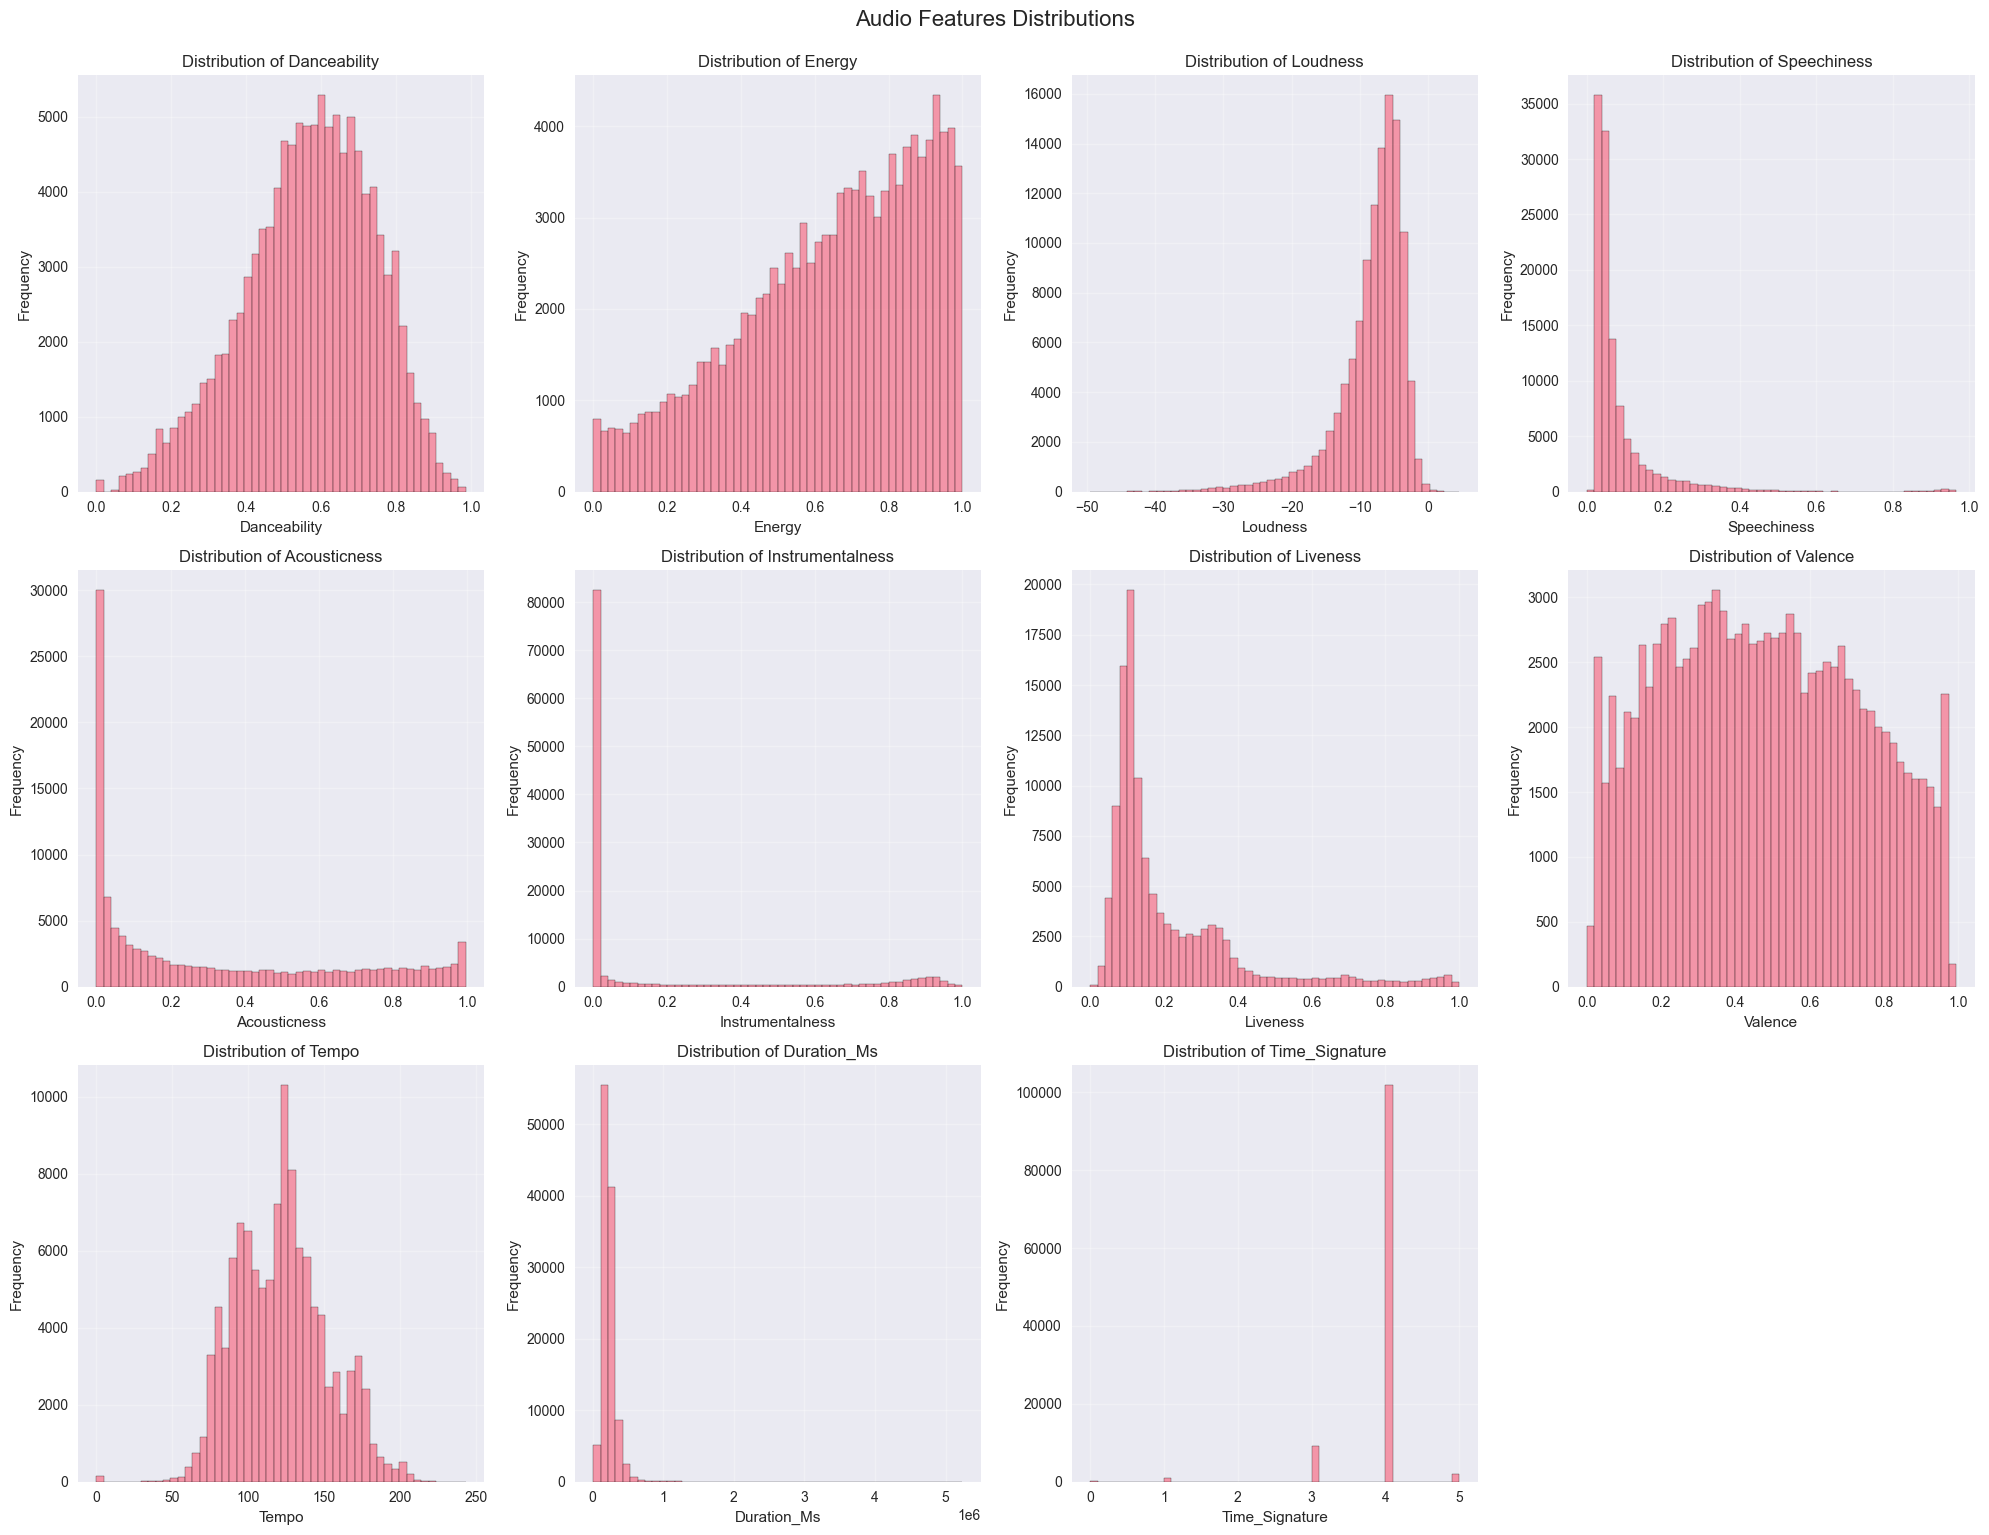

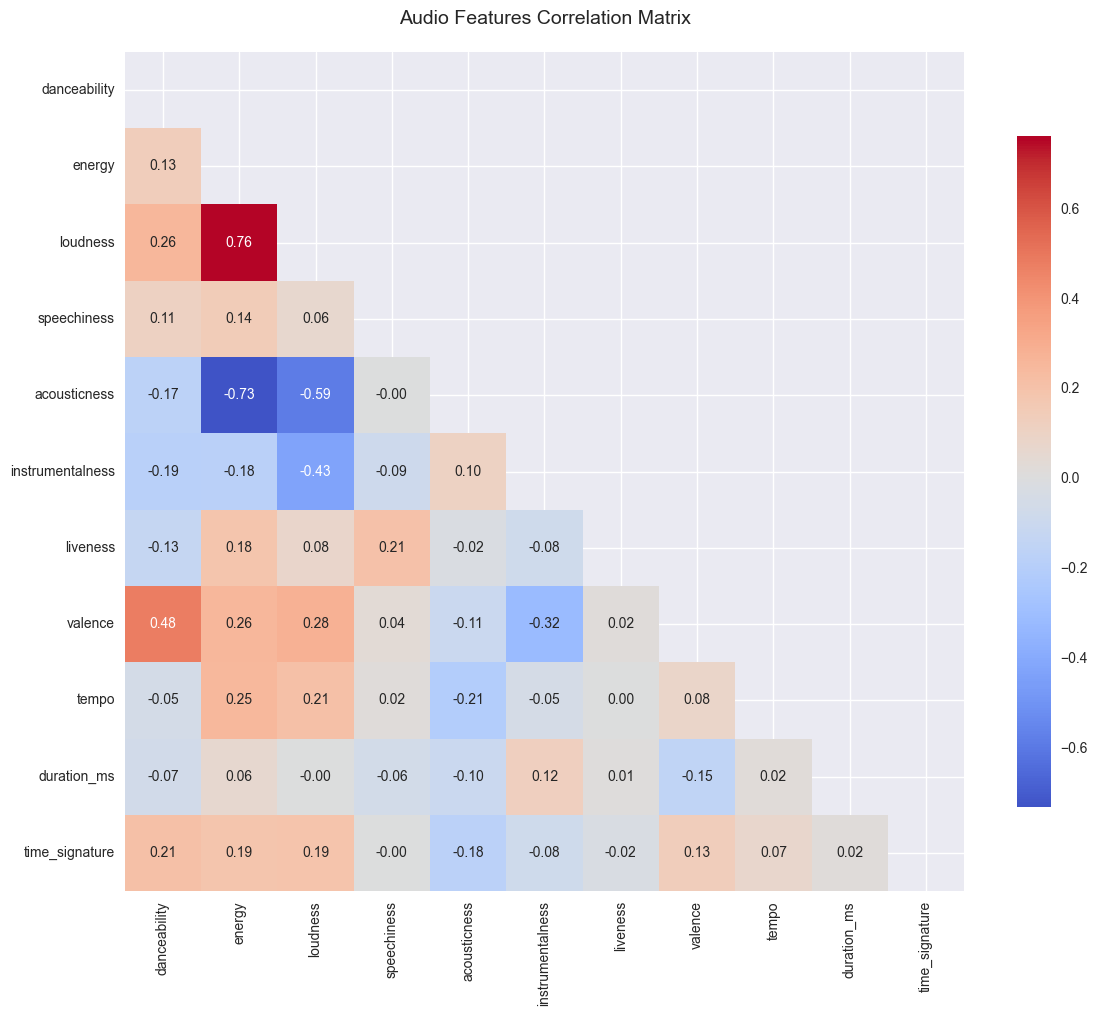

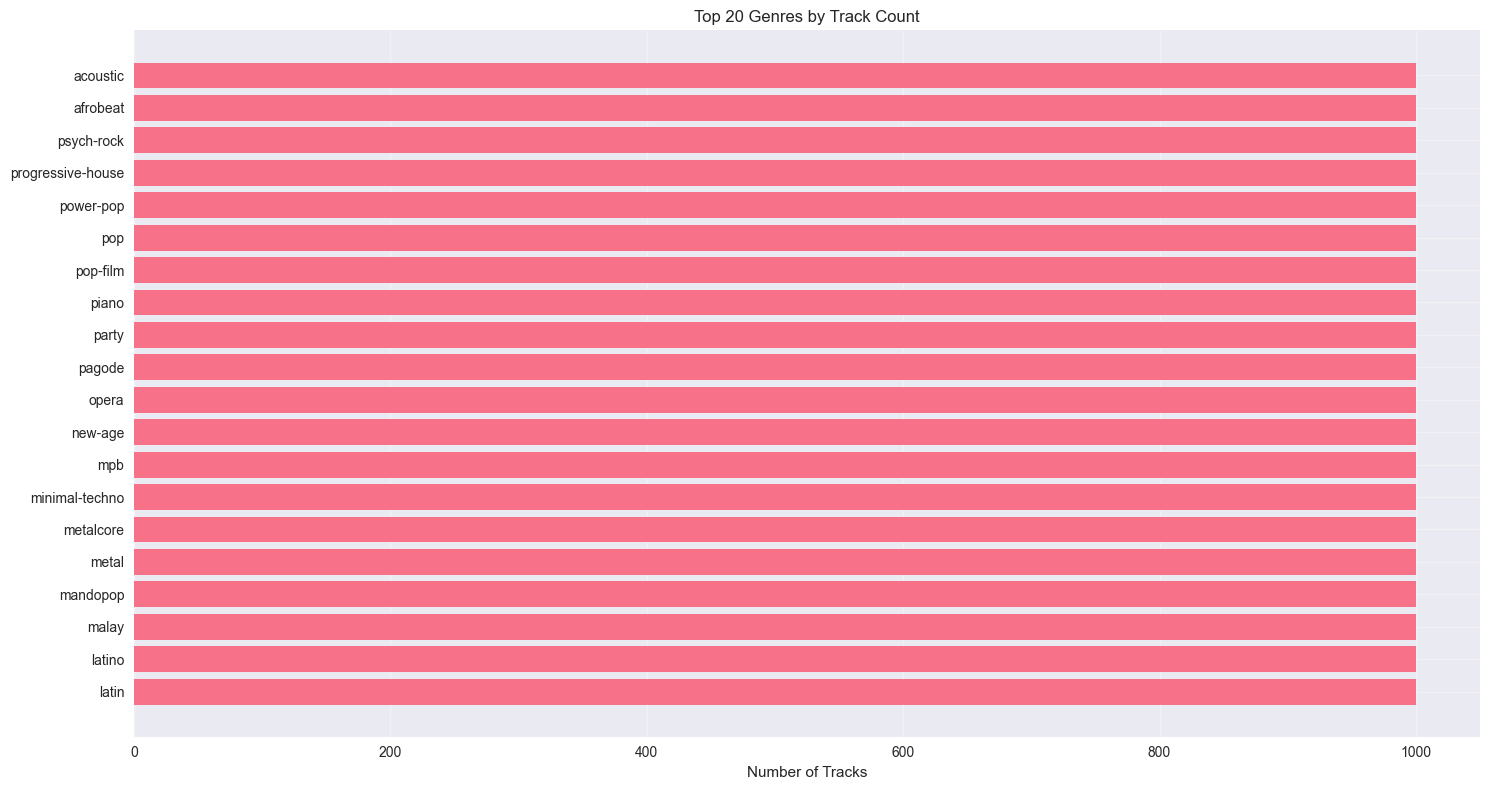

Total genres in dataset: 114
Most common genre: acoustic (1,000 tracks)


<Figure size 1200x1000 with 0 Axes>

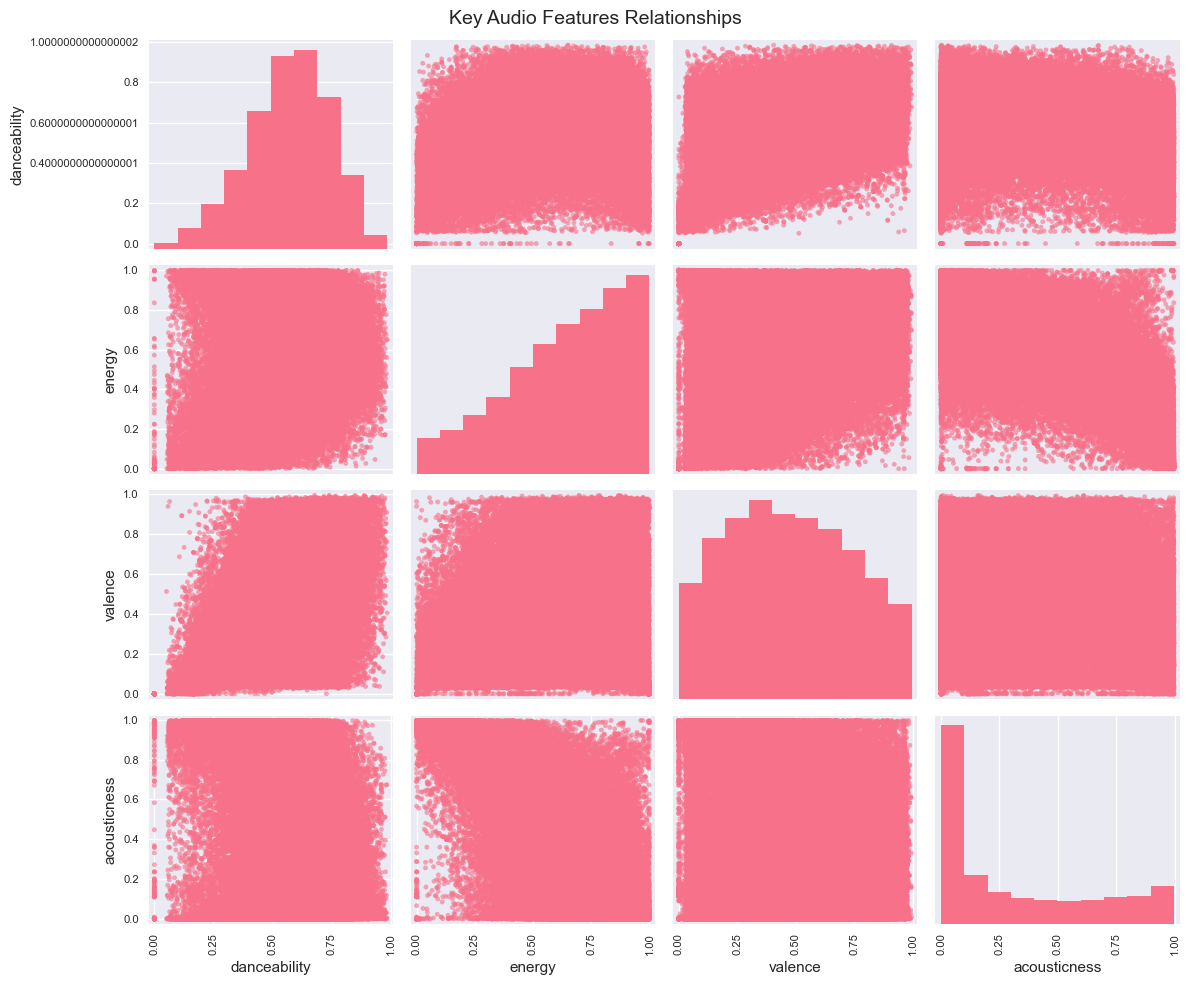


AUDIO FEATURES SUMMARY:


danceability      energy    loudness  speechiness  acousticness  \
count    113999.000  113999.000  113999.000   113999.000    113999.000   
mean          0.567       0.641      -8.259        0.085         0.315   
std           0.174       0.252       5.029        0.106         0.333   
min           0.000       0.000     -49.531        0.000         0.000   
25%           0.456       0.472     -10.013        0.036         0.017   
50%           0.580       0.685      -7.004        0.049         0.169   
75%           0.695       0.854      -5.003        0.084         0.597   
max           0.985       1.000       4.532        0.965         0.996   

       instrumentalness    liveness     valence       tempo  duration_ms  \
count        113999.000  113999.000  113999.000  113999.000   113999.000   
mean              0.156       0.214       0.474     122.148   228031.153   
std               0.310       0.190       0.259      29.978   107296.058   
min               0.000       0.000       0.000       0.000     8586.000   
25%               0.000       0.098       0.260      99.218   174066.000   
50%               0.000       0.132       0.464     122.017   212906.000   
75%               0.049       0.273       0.683     140.071   261506.000   
max               1.000       1.000       0.995     243.372  5237295.000   

       time_signature  
count      113999.000  
mean            3.904  
std             0.433  
min             0.000  
25%             4.000  
50%             4.000  
75%             4.000  
max             5.000

In [4]:
def perform_eda(df, audio_features):
    """
    Comprehensive exploratory data analysis
    """
    print("Starting exploratory data analysis...")
    
    # Audio features distribution
    plt.figure(figsize=(20, 15))
    n_features = len(audio_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    for i, feature in enumerate(audio_features, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.hist(df[feature], bins=50, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of {feature.title()}')
        plt.xlabel(feature.title())
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Audio Features Distributions', fontsize=16, y=1.02)
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[audio_features].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, mask=mask, annot=True, 
                cmap='coolwarm', center=0, square=True,
                fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Audio Features Correlation Matrix', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Genre distribution
    plt.figure(figsize=(15, 8))
    genre_counts = df['track_genre'].value_counts().head(20)
    plt.barh(range(len(genre_counts)), genre_counts.values)
    plt.yticks(range(len(genre_counts)), genre_counts.index)
    plt.xlabel('Number of Tracks')
    plt.title('Top 20 Genres by Track Count')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total genres in dataset: {df['track_genre'].nunique()}")
    print(f"Most common genre: {df['track_genre'].mode()[0]} ({df['track_genre'].value_counts().iloc[0]:,} tracks)")
    
    # Feature relationships
    key_features = ['danceability', 'energy', 'valence', 'acousticness']
    key_features = [f for f in key_features if f in audio_features]
    
    if len(key_features) >= 2:
        plt.figure(figsize=(12, 10))
        pd.plotting.scatter_matrix(df[key_features], figsize=(12, 10), 
                                 alpha=0.6, diagonal='hist')
        plt.suptitle('Key Audio Features Relationships', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # Summary statistics
    print("\nAUDIO FEATURES SUMMARY:")
    print("=" * 50)
    summary_stats = df[audio_features].describe()
    display(summary_stats.round(3))
    
    return correlation_matrix

if df is not None:
    correlation_matrix = perform_eda(df_clean, audio_features)
    

## Feature engineering

In [5]:
def engineer_features(df, audio_features):
    """
    Create additional features that could be useful for clustering
    """
    print("Engineering additional features...")
    
    df_engineered = df.copy()
    
    # Composite features
    df_engineered['energy_danceability'] = df['energy'] * df['danceability']
    print("Created: energy_danceability")

    df_engineered['mood_energy'] = df['valence'] * df['energy']
    print("Created: mood_energy")
    
    df_engineered['acoustic_instrumental'] = (df['acousticness'] + df['instrumentalness']) / 2
    print("Created: acoustic_instrumental")
    
    # Normalized tempo
    df_engineered['tempo_normalized'] = (df['tempo'] - df['tempo'].min()) / (df['tempo'].max() - df['tempo'].min())
    print("Created: tempo_normalized")
    
    # Loudness normalized (convert from dB to positive scale)
    df_engineered['loudness_normalized'] = (df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
    print("Created: loudness_normalized")
    
    # Update feature list
    new_features = ['energy_danceability', 'mood_energy', 'acoustic_instrumental', 
                   'tempo_normalized', 'loudness_normalized']
    engineered_features = audio_features + [f for f in new_features if f in df_engineered.columns]
    
    print(f"Total features for clustering: {len(engineered_features)}")
    return df_engineered, engineered_features

if df is not None:
    df_engineered, clustering_features = engineer_features(df_clean, audio_features)


Engineering additional features...
Created: energy_danceability
Created: mood_energy
Created: acoustic_instrumental
Created: tempo_normalized
Created: loudness_normalized
Total features for clustering: 16


## Data preparation for clustering

In [6]:
def prepare_clustering_data(df, features):
    """
    Prepare and scale data for clustering algorithms
    """
    print("Preparing data for clustering...")
    
    X = df[features].copy()
    X = X.fillna(X.median())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=features)
    
    print(f"Feature matrix prepared: {X_scaled.shape}")
    print(f"Features used: {features}")
    
    return X_scaled, X_scaled_df, scaler

if df is not None:
    X_scaled, X_scaled_df, scaler = prepare_clustering_data(df_engineered, clustering_features)
    
    print("\nScaled Features Preview:")
    display(X_scaled_df.head())
    
    print("\nScaled Features Statistics:")
    display(X_scaled_df.describe().round(3))


Preparing data for clustering...
Feature matrix prepared: (113999, 16)
Features used: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'energy_danceability', 'mood_energy', 'acoustic_instrumental', 'tempo_normalized', 'loudness_normalized']

Scaled Features Preview:


danceability    energy  loudness  speechiness  acousticness  \
0      0.629239 -0.717147  0.300825     0.551843     -0.850193   
1     -0.845908 -1.889974 -1.784739    -0.078995      1.831744   
2     -0.742187 -1.122667 -0.293289    -0.273827     -0.315489   
3     -1.733301 -2.312987 -2.039246    -0.457309      1.774605   
4      0.295026 -0.788709 -0.282751    -0.303146      0.463409   

   instrumentalness  liveness   valence     tempo  duration_ms  \
0         -0.504111  0.758735  0.929315 -1.141854     0.024557   
1         -0.504097 -0.591216 -0.798681 -1.489708    -0.730889   
2         -0.504115 -0.507172 -1.365679 -1.528303    -0.160353   
3         -0.503886 -0.428381 -1.276965  1.987857    -0.243236   
4         -0.504115 -0.686290 -1.184394 -0.073343    -0.271942   

   time_signature  energy_danceability  mood_energy  acoustic_instrumental  \
0        0.221824            -0.324782     0.038699              -0.919256   
1        0.221824            -1.684977    -1.234525               0.949198   
2        0.221824            -1.192877    -1.240068              -0.546742   
3       -2.089669            -1.987846    -1.394292               0.909527   
4        0.221824            -0.537665    -1.102161              -0.004102   

   tempo_normalized  loudness_normalized  
0         -1.141854             0.300825  
1         -1.489708            -1.784739  
2         -1.528303            -0.293289  
3          1.987857            -2.039246  
4         -0.073343            -0.282751


Scaled Features Statistics:


danceability      energy    loudness  speechiness  acousticness  \
count    113999.000  113999.000  113999.000   113999.000    113999.000   
mean         -0.000       0.000       0.000        0.000        -0.000   
std           1.000       1.000       1.000        1.000         1.000   
min          -3.266      -2.550      -8.206       -0.801        -0.947   
25%          -0.638      -0.673      -0.349       -0.461        -0.896   
50%           0.076       0.173       0.250       -0.338        -0.439   
75%           0.739       0.845       0.647       -0.001         0.850   
max           2.410       1.426       2.543        8.326         2.048   

       instrumentalness    liveness     valence       tempo  duration_ms  \
count        113999.000  113999.000  113999.000  113999.000   113999.000   
mean             -0.000       0.000      -0.000       0.000       -0.000   
std               1.000       1.000       1.000       1.000        1.000   
min              -0.504      -1.122      -1.829      -4.075       -2.045   
25%              -0.504      -0.607      -0.826      -0.765       -0.503   
50%              -0.504      -0.428      -0.039      -0.004       -0.141   
75%              -0.346       0.312       0.806       0.598        0.312   
max               2.726       4.131       2.009       4.044       46.687   

       time_signature  energy_danceability  mood_energy  \
count      113999.000           113999.000   113999.000   
mean           -0.000                0.000       -0.000   
std             1.000                1.000        1.000   
min            -9.024               -2.077       -1.432   
25%             0.222               -0.735       -0.854   
50%             0.222                0.073       -0.142   
75%             0.222                0.745        0.732   
max             2.533                3.301        2.906   

       acoustic_instrumental  tempo_normalized  loudness_normalized  
count             113999.000        113999.000           113999.000  
mean                   0.000             0.000                0.000  
std                    1.000             1.000                1.000  
min                   -0.987            -4.075               -8.206  
25%                   -0.851            -0.765               -0.349  
50%                   -0.295            -0.004                0.250  
75%                    0.624             0.598                0.647  
max                    3.193             4.044                2.543

## Dimensionality reduction for visualization

Performing dimensionality reduction...
PCA explained variance ratio: [0.35789542 0.12737512]
Total variance explained: 0.485
Computing t-SNE (may take a while)...


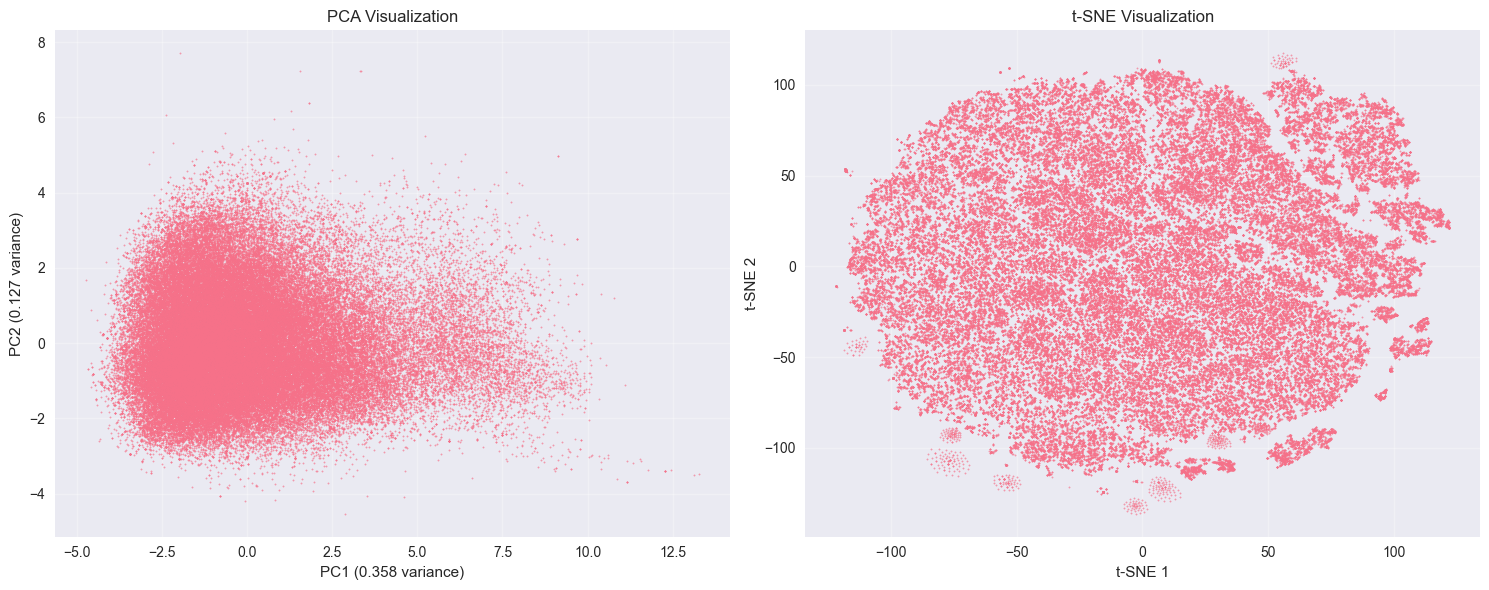

In [7]:
def perform_dimensionality_reduction(X_scaled):
    """
    Apply PCA and t-SNE for visualization
    """
    print("Performing dimensionality reduction...")
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")
    
    # t-SNE
    print("Computing t-SNE (may take a while)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    return X_pca, X_tsne, pca

if df is not None:
    X_pca, X_tsne, pca = perform_dimensionality_reduction(X_scaled)
    
    # Visualize dimensionality reduction
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # PCA plot
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=1)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
    ax1.set_title('PCA Visualization')
    ax1.grid(True, alpha=0.3)
    
    # t-SNE plot
    ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=1)
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_title('t-SNE Visualization')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Advanced data preprocessing and optimizations

ADVANCED PREPROCESSING
Handling outliers for better clustering...
Outlier handling complete. Method: clip
Dataset shape after handling: (113999, 26)
Development sample created: (24966, 26)
Genres represented: 114
Preparing data for clustering...
Feature matrix prepared: (24966, 16)
Features used: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'energy_danceability', 'mood_energy', 'acoustic_instrumental', 'tempo_normalized', 'loudness_normalized']


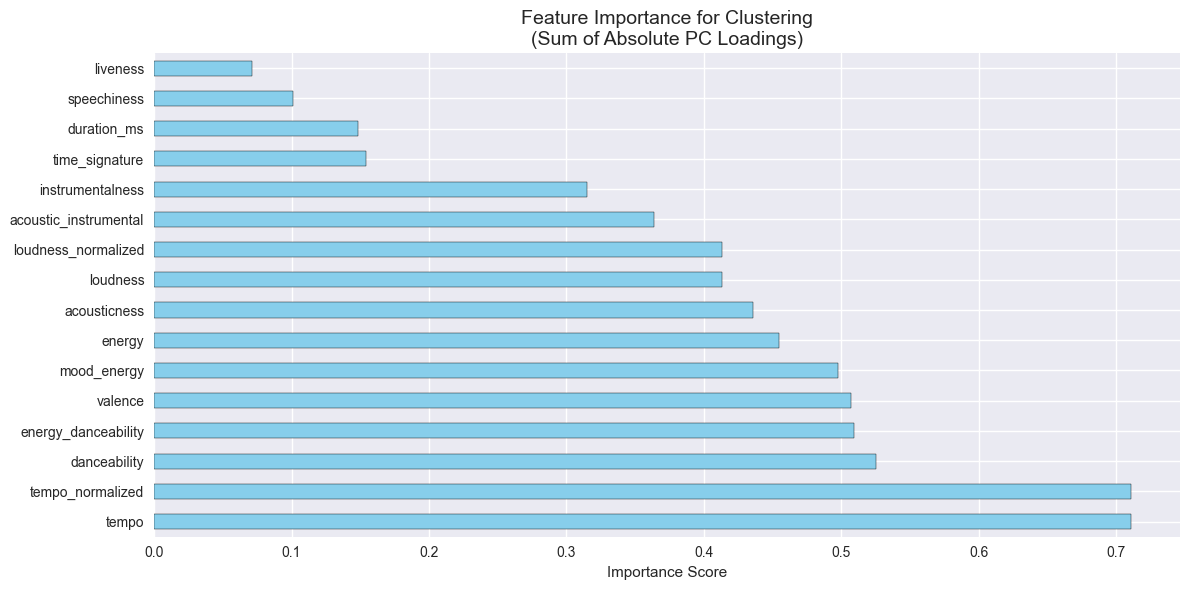

TOP 10 MOST IMPORTANT FEATURES FOR CLUSTERING:
 1. tempo                     0.711
 2. tempo_normalized          0.711
 3. danceability              0.525
 4. energy_danceability       0.509
 5. valence                   0.507
 6. mood_energy               0.498
 7. energy                    0.455
 8. acousticness              0.436
 9. loudness                  0.413
10. loudness_normalized       0.413


In [8]:
def handle_outliers(df, features, method='clip'):
    """
    Handle outliers using IQR method to improve clustering quality
    """
    df_cleaned = df.copy()
    outlier_summary = {}
    
    print("Handling outliers for better clustering...")
    for feature in features:
        if feature in df_cleaned.columns:
            Q1 = df_cleaned[feature].quantile(0.25)
            Q3 = df_cleaned[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers before handling
            outliers_before = ((df_cleaned[feature] < lower_bound) | 
                             (df_cleaned[feature] > upper_bound)).sum()
            
            if method == 'clip':
                # Clip extreme vals to boundaries
                df_cleaned[feature] = df_cleaned[feature].clip(lower_bound, upper_bound)
            
            outlier_summary[feature] = outliers_before
    
    print(f"Outlier handling complete. Method: {method}")
    print(f"Dataset shape after handling: {df_cleaned.shape}")
    
    return df_cleaned, outlier_summary

def create_development_sample(df, sample_size=25000, random_state=42):
    """
    Create stratified sample for faster algorithm development
    """
    sample_df = df.groupby('track_genre').apply(
        lambda x: x.sample(min(len(x), max(1, sample_size // df['track_genre'].nunique())), 
                          random_state=random_state)
    ).reset_index(drop=True)
    
    print(f"Development sample created: {sample_df.shape}")
    print(f"Genres represented: {sample_df['track_genre'].nunique()}")
    
    return sample_df

def analyze_feature_importance(X_scaled_df, pca, feature_names):
    """
    Analyze feature contributions to understand data structure
    """
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=feature_names
    )
    
    # Feature importance based on absolute loadings
    feature_importance = np.abs(components_df).sum(axis=1).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    feature_importance.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title('Feature Importance for Clustering\n(Sum of Absolute PC Loadings)', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("TOP 10 MOST IMPORTANT FEATURES FOR CLUSTERING:")
    for i, (feature, score) in enumerate(feature_importance.head(10).items(), 1):
        print(f"{i:2d}. {feature:<25} {score:.3f}")
    
    return feature_importance, components_df

if df is not None:
    print("ADVANCED PREPROCESSING")
    
    # Handle outliers
    df_optimized, outlier_info = handle_outliers(df_engineered, clustering_features, method='clip')
    
    # Create development sample for faster iteration
    df_sample = create_development_sample(df_optimized, sample_size=25000)
    
    # Re-prepare data with optimized dataset
    X_sample_scaled, X_sample_scaled_df, sample_scaler = prepare_clustering_data(df_sample, clustering_features)
    
    # Analyze feature importance
    feature_importance, components_df = analyze_feature_importance(X_scaled_df, pca, clustering_features)


## Clustering validation framework

In [9]:
from sklearn.metrics import (
    silhouette_score, 
    calinski_harabasz_score, 
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)

def evaluate_clustering(X, labels, true_labels=None, algorithm_name="Unknown"):
    """
    Comprehensive clustering evaluation with multiple metrics
    """
    results = {}
    
    # Handle noise points
    valid_mask = labels != -1
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    if len(np.unique(labels_valid)) > 1:
        # Validation metrics
        results['silhouette_score'] = silhouette_score(X_valid, labels_valid)
        results['calinski_harabasz_score'] = calinski_harabasz_score(X_valid, labels_valid)
        results['davies_bouldin_score'] = davies_bouldin_score(X_valid, labels_valid)
        
        # Cluster stats
        results['n_clusters'] = len(np.unique(labels_valid))
        results['n_noise'] = np.sum(labels == -1)
        results['noise_ratio'] = np.sum(labels == -1) / len(labels)
        
        # External validation
        if true_labels is not None:
            true_labels_valid = np.array(true_labels)[valid_mask]
            results['adjusted_rand_score'] = adjusted_rand_score(true_labels_valid, labels_valid)
            results['adjusted_mutual_info'] = adjusted_mutual_info_score(true_labels_valid, labels_valid)
    
    results['algorithm'] = algorithm_name
    return results

def visualize_clusters(X_pca, X_tsne, labels, algorithm_name, true_labels=None):
    """
    Visualize clustering results on PCA and t-SNE plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    # PCA plot
    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                          c='black', marker='x', s=20, alpha=0.6, label='Noise')
        else:
            axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                          c=[colors[i]], s=20, alpha=0.7, label=f'Cluster {label}')
    
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_title(f'{algorithm_name} - PCA View')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # t-SNE plot
    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c='black', marker='x', s=20, alpha=0.6, label='Noise')
        else:
            axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c=[colors[i]], s=20, alpha=0.7, label=f'Cluster {label}')
    
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].set_title(f'{algorithm_name} - t-SNE View')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

## 1. K-means clustering

Finding optimal K...
K=5: Silhouette=0.157
K=10: Silhouette=0.128
K=15: Silhouette=0.123


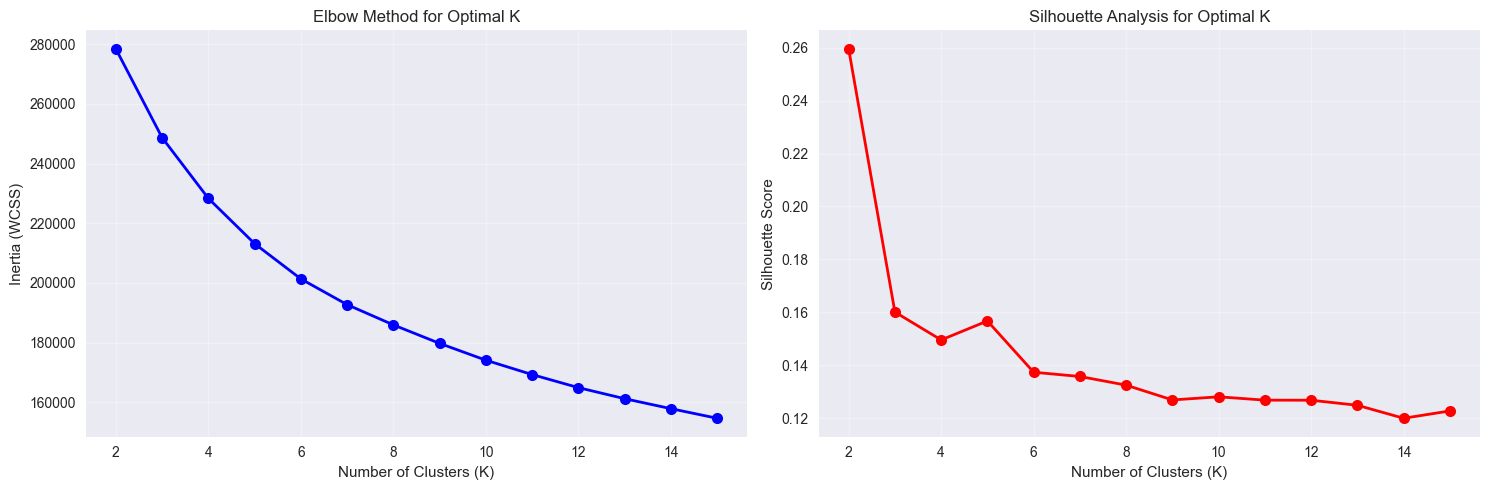


OPTIMAL K = 2 (Silhouette Score: 0.260)

Applying K-Means with K=2...
Number of clusters: 2
Silhouette score: 0.260
Calinski-Harabasz score: 8615.6
Davies-Bouldin score: 1.512


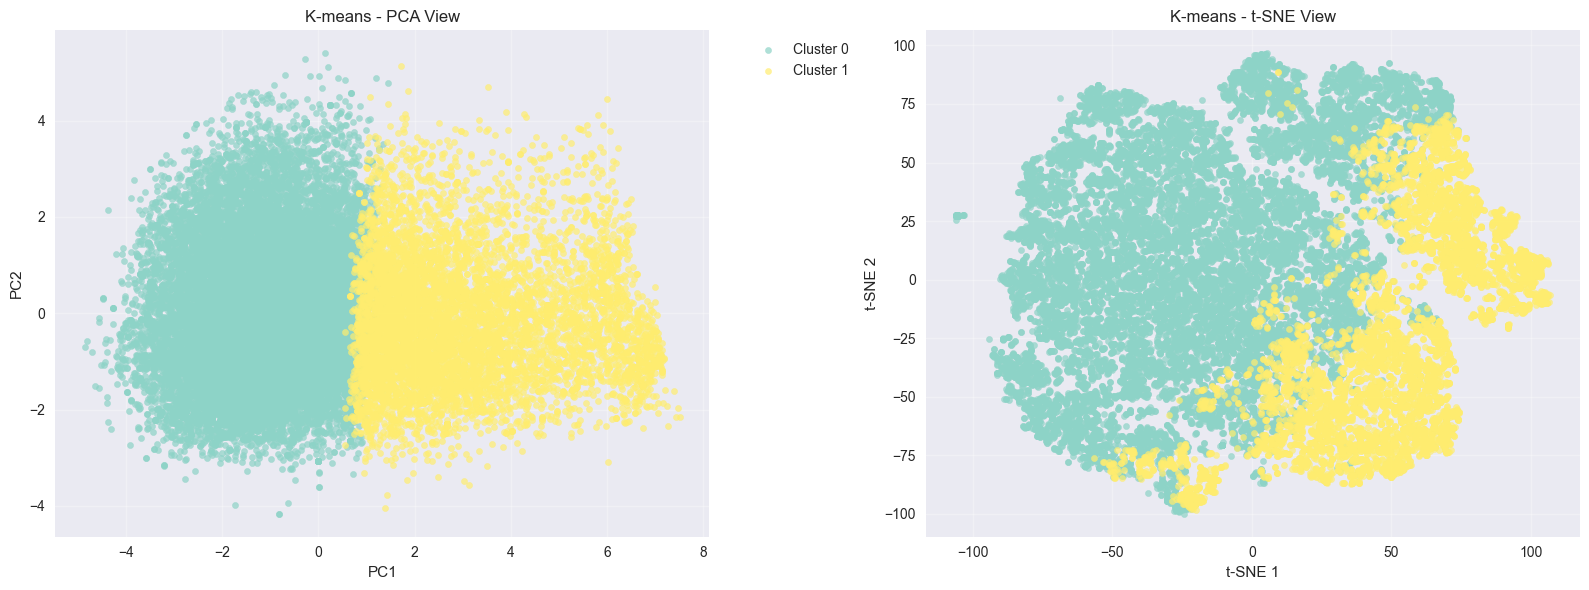

In [10]:
def find_optimal_k_kmeans(X, max_k=20):
    """
    Find optimal number of clusters using elbow method and silhouette analysis
    """
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    print("Finding optimal K...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        
        if k % 5 == 0:
            print(f"K={k}: Silhouette={silhouette_scores[-1]:.3f}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow method
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Inertia (WCSS)')
    ax1.set_title('Elbow Method for Optimal K')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis for Optimal K')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find highest silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOPTIMAL K = {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")
    
    return optimal_k, silhouette_scores

# Find optimal K
optimal_k, silhouette_scores = find_optimal_k_kmeans(X_sample_scaled, max_k=15)

# Apply K-means with optimal K
print(f"\nApplying K-Means with K={optimal_k}...")
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_sample_scaled)

kmeans_results = evaluate_clustering(X_sample_scaled, kmeans_labels, 
                                   df_sample['track_genre'], "K-means")

print(f"Number of clusters: {kmeans_results['n_clusters']}")
print(f"Silhouette score: {kmeans_results['silhouette_score']:.3f}")
print(f"Calinski-Harabasz score: {kmeans_results['calinski_harabasz_score']:.1f}")
print(f"Davies-Bouldin score: {kmeans_results['davies_bouldin_score']:.3f}")

X_sample_pca = pca.transform(X_sample_scaled)
tsne_sample = TSNE(n_components=2, random_state=42, perplexity=30)
X_sample_tsne = tsne_sample.fit_transform(X_sample_scaled)

visualize_clusters(X_sample_pca, X_sample_tsne, kmeans_labels, "K-means")


## 2. Hierarchical clustering

Performing hierarchical clustering...


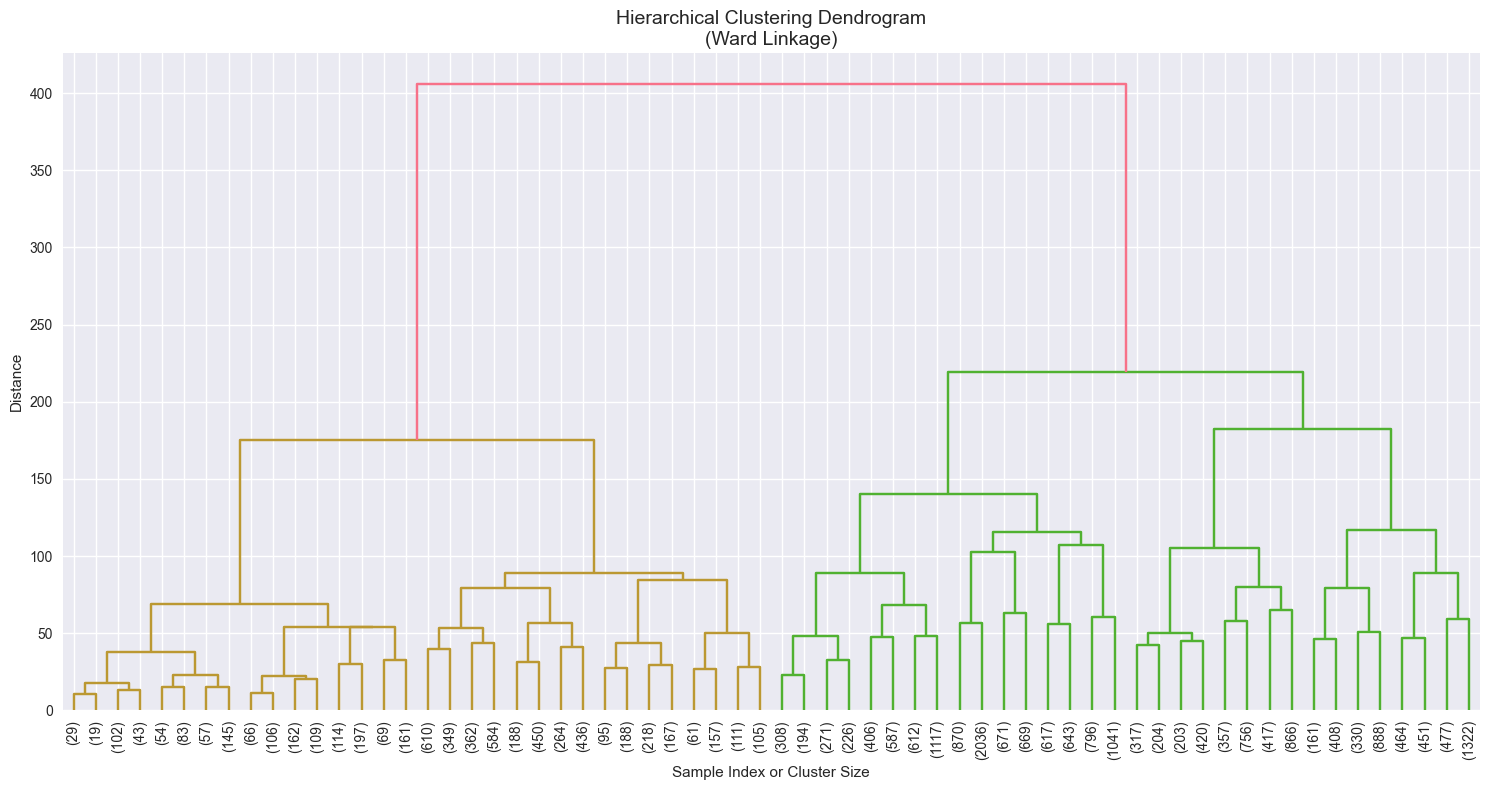

Optimal clusters for Hierarchical: 2
Number of clusters: 2
Silhouette score: 0.239
Calinski-Harabasz score: 7029.4
Davies-Bouldin score: 1.546


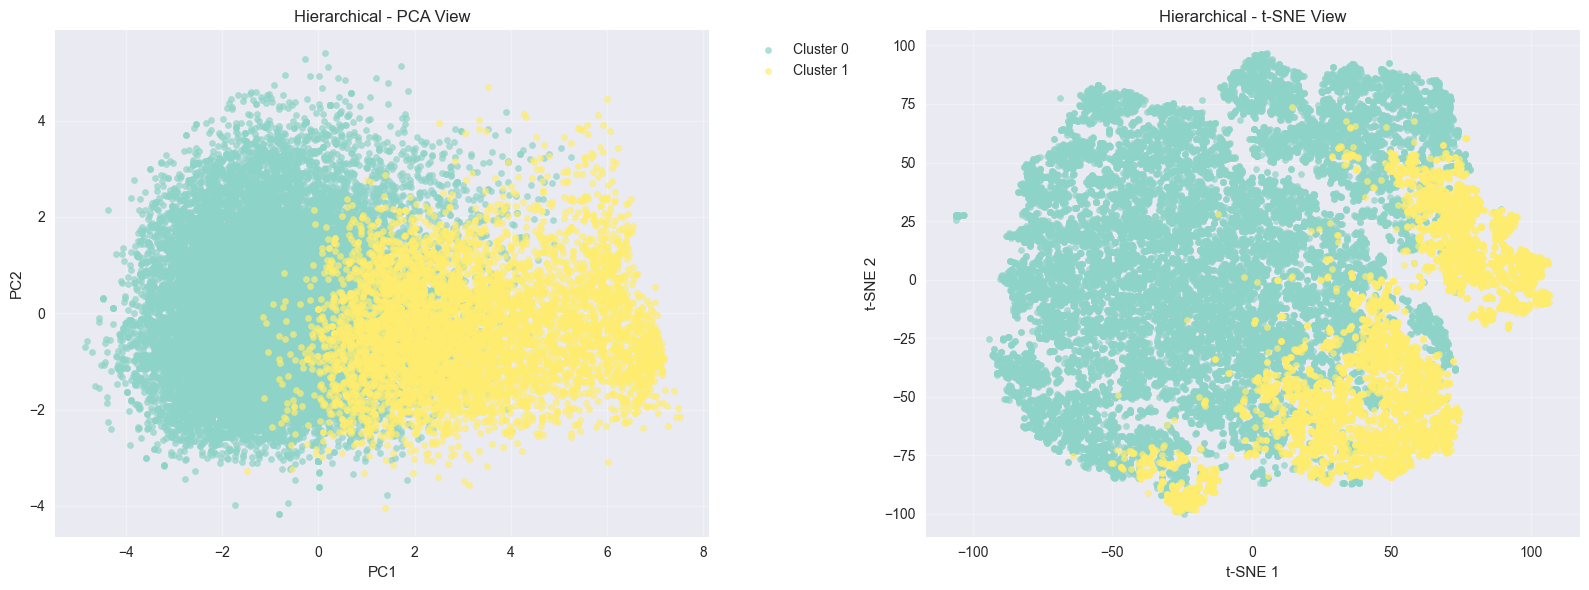

In [11]:
def perform_hierarchical_clustering(X, max_clusters=15):
    """
    Perform hierarchical clustering with dendrogram analysis
    """
    from scipy.cluster.hierarchy import dendrogram, linkage
    
    print("Performing hierarchical clustering...")
    
    # Compute linkage matrix
    linkage_matrix = linkage(X, method='ward')
    
    plt.figure(figsize=(15, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, 
               leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram\n(Ward Linkage)', fontsize=14)
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()
    
    # Find optimal number of clusters
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    for k in k_range:
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = hierarchical.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal clusters for Hierarchical: {optimal_k}")
    
    # Apply hierarchical clustering with optimal K
    hierarchical_optimal = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
    hierarchical_labels = hierarchical_optimal.fit_predict(X)
    
    return hierarchical_labels, optimal_k

hierarchical_labels, hier_optimal_k = perform_hierarchical_clustering(X_sample_scaled)

# Evaluate Hierarchical Clustering
hier_results = evaluate_clustering(X_sample_scaled, hierarchical_labels, 
                                 df_sample['track_genre'], "Hierarchical")

print(f"Number of clusters: {hier_results['n_clusters']}")
print(f"Silhouette score: {hier_results['silhouette_score']:.3f}")
print(f"Calinski-Harabasz score: {hier_results['calinski_harabasz_score']:.1f}")
print(f"Davies-Bouldin score: {hier_results['davies_bouldin_score']:.3f}")

visualize_clusters(X_sample_pca, X_sample_tsne, hierarchical_labels, "Hierarchical")


## 3. DBSCAN clustering

Tuning DBSCAN parameters for clustering...

Top 5 practical DBSCAN parameter combinations:
    eps  min_samples  n_clusters  silhouette_score  noise_ratio
19  2.0           25           2             0.299        0.047
18  2.0           20           2             0.296        0.038
17  2.0           15           2             0.292        0.029
23  2.3           30           2             0.286        0.014
24  2.6           25           2             0.286        0.003

Best DBSCAN parameters: eps=2.0, min_samples=25
Number of clusters: 2
Noise points: 1162 (4.7%)
Silhouette score: 0.299
Calinski-Harabasz score: 70.8
Davies-Bouldin score: 0.777


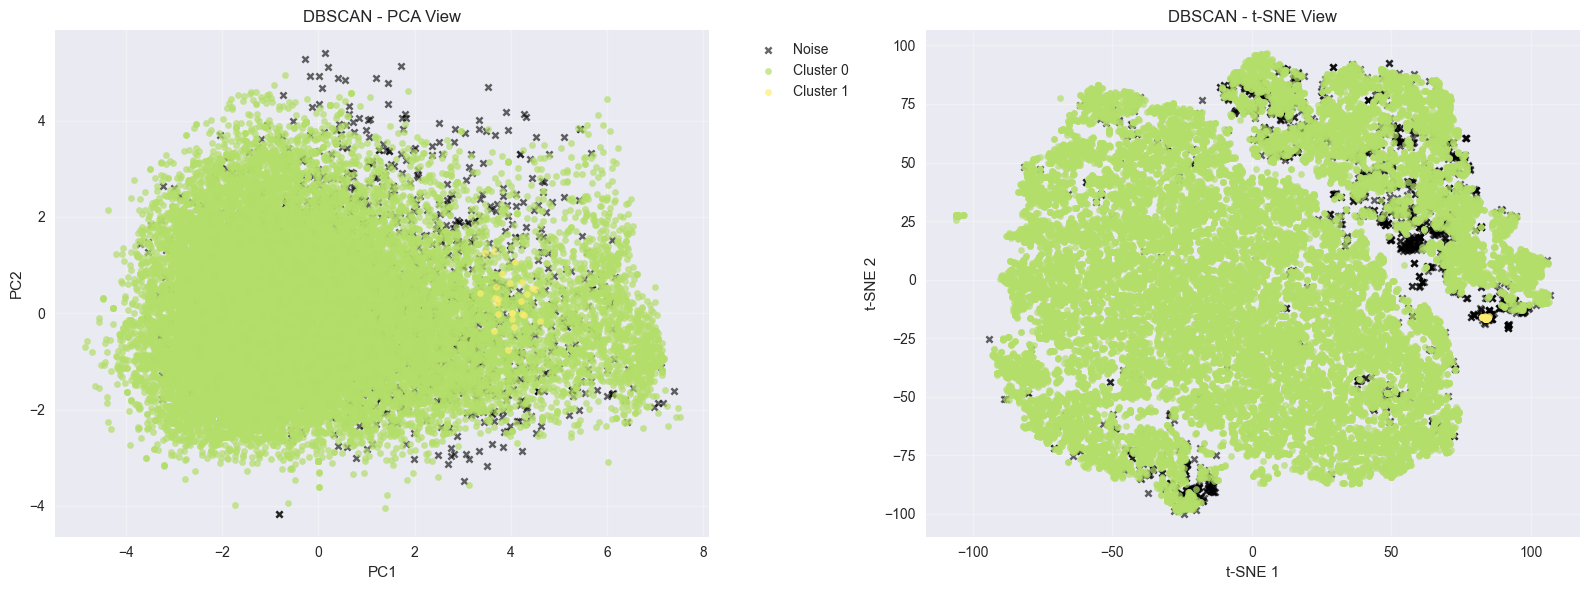

In [12]:
def find_optimal_dbscan_params(X, eps_range=None, min_samples_range=None):
    """
    Find optimal DBSCAN parameters
    """
    if eps_range is None:
        eps_range = np.arange(0.5, 3.0, 0.3)
    if min_samples_range is None:
        min_samples_range = range(15, 50, 5)
    
    best_score = -1
    best_params = {}
    results = []
    
    print("Tuning DBSCAN parameters for clustering...")
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Check for valid clusters
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = np.sum(labels == -1) / len(labels)
            
            if 2 <= n_clusters <= 20 and noise_ratio < 0.8:
                valid_mask = labels != -1
                if np.sum(valid_mask) > 50:
                    score = silhouette_score(X[valid_mask], labels[valid_mask])
                    
                    results.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'silhouette_score': score,
                        'noise_ratio': noise_ratio
                    })
                    
                    adjusted_score = score * (1 - noise_ratio) * (1 / max(1, n_clusters/10))
                    if adjusted_score > best_score:
                        best_score = adjusted_score
                        best_params = {'eps': eps, 'min_samples': min_samples}
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print("\nTop 5 practical DBSCAN parameter combinations:")
        top_results = results_df.nlargest(5, 'silhouette_score')
        print(top_results.round(3))
        
        if not best_params:
            best_idx = results_df['silhouette_score'].idxmax()
            best_params = {
                'eps': results_df.loc[best_idx, 'eps'],
                'min_samples': results_df.loc[best_idx, 'min_samples']
            }
    else:
        print("No suitable parameters found")
        best_params = {'eps': 1.0, 'min_samples': 20}
    
    print(f"\nBest DBSCAN parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    return best_params

# Find optimal parameters
best_dbscan_params = find_optimal_dbscan_params(X_sample_scaled)

# Apply DBSCAN with optimal parameters
dbscan_optimal = DBSCAN(eps=best_dbscan_params['eps'], 
                       min_samples=best_dbscan_params['min_samples'])
dbscan_labels = dbscan_optimal.fit_predict(X_sample_scaled)

dbscan_results = evaluate_clustering(X_sample_scaled, dbscan_labels, 
                                   df_sample['track_genre'], "DBSCAN")

print(f"Number of clusters: {dbscan_results['n_clusters']}")
print(f"Noise points: {dbscan_results['n_noise']} ({dbscan_results['noise_ratio']:.1%})")
print(f"Silhouette score: {dbscan_results['silhouette_score']:.3f}")
print(f"Calinski-Harabasz score: {dbscan_results['calinski_harabasz_score']:.1f}")
print(f"Davies-Bouldin score: {dbscan_results['davies_bouldin_score']:.3f}")

def visualize_clusters(X_pca, X_tsne, labels, algorithm_name):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters > 20:
        colors = plt.cm.tab20(np.linspace(0, 1, min(20, n_clusters)))
        show_legend = False
        print(f"Note: {n_clusters} clusters found. Legend disabled for readability.")
    else:
        colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
        show_legend = True
    
    # PCA plot
    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:  # Noise points
            axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                          c='black', marker='x', s=20, alpha=0.6, 
                          label='Noise' if show_legend else None)
        else:
            color_idx = i % len(colors)
            axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                          c=[colors[color_idx]], s=20, alpha=0.7, 
                          label=f'Cluster {label}' if show_legend and i < 10 else None)
    
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_title(f'{algorithm_name} - PCA View')
    if show_legend:
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # t-SNE plot
    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:  # Noise points
            axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c='black', marker='x', s=20, alpha=0.6)
        else:
            color_idx = i % len(colors)
            axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c=[colors[color_idx]], s=20, alpha=0.7)
    
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].set_title(f'{algorithm_name} - t-SNE View')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if n_clusters > 10:
        print(f"\nCluster Summary ({algorithm_name}):")
        print(f"Total clusters: {n_clusters}")
        print(f"Largest cluster: {np.max(np.bincount(labels[labels != -1]))} tracks")
        print(f"Smallest cluster: {np.min(np.bincount(labels[labels != -1]))} tracks")
        print(f"Average cluster size: {np.mean(np.bincount(labels[labels != -1])):.1f} tracks")

visualize_clusters(X_sample_pca, X_sample_tsne, dbscan_labels, "DBSCAN")


## 4. Gaussian mixture models

Finding optimal GMM components...


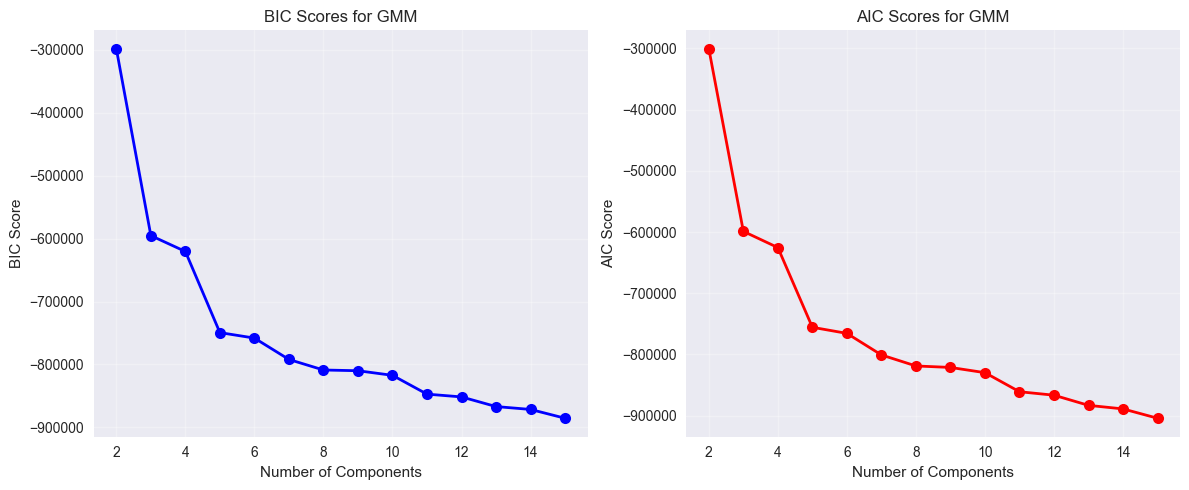

Optimal GMM components: 15 (BIC: -885499.0)
Number of components: 15
Silhouette score: 0.011
Calinski-Harabasz score: 1426.6
Davies-Bouldin score: 4.222


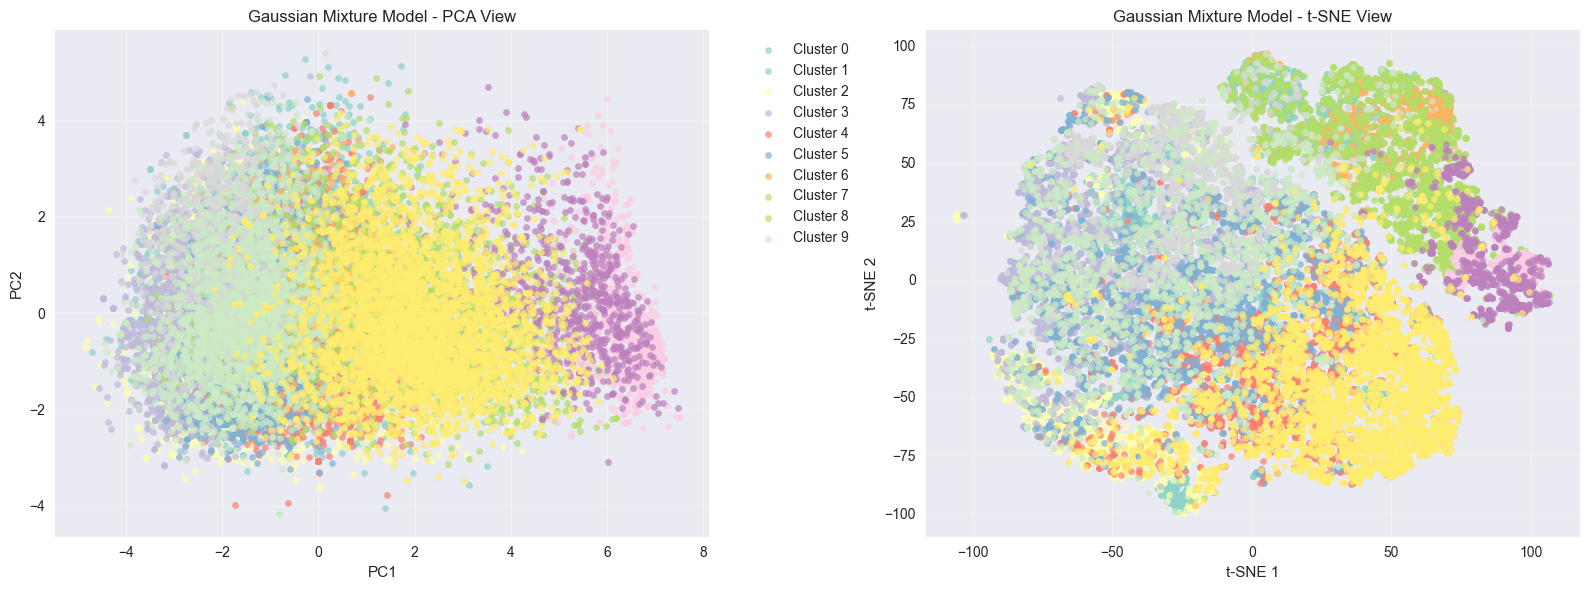


Cluster Summary (Gaussian Mixture Model):
Total clusters: 15
Largest cluster: 3107 tracks
Smallest cluster: 637 tracks
Average cluster size: 1664.4 tracks


In [13]:
def find_optimal_gmm_components(X, max_components=15):
    """
    Find optimal number of components using BIC and AIC
    """
    n_components_range = range(2, max_components + 1)
    bic_scores = []
    aic_scores = []
    
    print("Finding optimal GMM components...")
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.title('BIC Scores for GMM')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, aic_scores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components')
    plt.ylabel('AIC Score')
    plt.title('AIC Scores for GMM')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Optimal/lowest BIC components
    optimal_components = n_components_range[np.argmin(bic_scores)]
    print(f"Optimal GMM components: {optimal_components} (BIC: {min(bic_scores):.1f})")
    
    return optimal_components

optimal_gmm_components = find_optimal_gmm_components(X_sample_scaled)

# Apply GMM with optimal components
gmm_optimal = GaussianMixture(n_components=optimal_gmm_components, random_state=42)
gmm_optimal.fit(X_sample_scaled)
gmm_labels = gmm_optimal.predict(X_sample_scaled)

# Evaluate GMM
gmm_results = evaluate_clustering(X_sample_scaled, gmm_labels, 
                                df_sample['track_genre'], "GMM")

print(f"Number of components: {gmm_results['n_clusters']}")
print(f"Silhouette score: {gmm_results['silhouette_score']:.3f}")
print(f"Calinski-Harabasz score: {gmm_results['calinski_harabasz_score']:.1f}")
print(f"Davies-Bouldin score: {gmm_results['davies_bouldin_score']:.3f}")

visualize_clusters(X_sample_pca, X_sample_tsne, gmm_labels, "Gaussian Mixture Model")

## Algorithm comparison

silhouette_score  calinski_harabasz_score  davies_bouldin_score  \
0             0.260                 8615.596                 1.512   
1             0.239                 7029.438                 1.546   
2             0.299                   70.785                 0.777   
3             0.011                 1426.628                 4.222   

   n_clusters  n_noise  noise_ratio  adjusted_rand_score  \
0           2        0        0.000                0.004   
1           2        0        0.000                0.003   
2           2     1162        0.047                0.000   
3          15        0        0.000                0.021   

   adjusted_mutual_info     algorithm  
0                 0.070       K-means  
1                 0.064  Hierarchical  
2                 0.002        DBSCAN  
3                 0.169           GMM

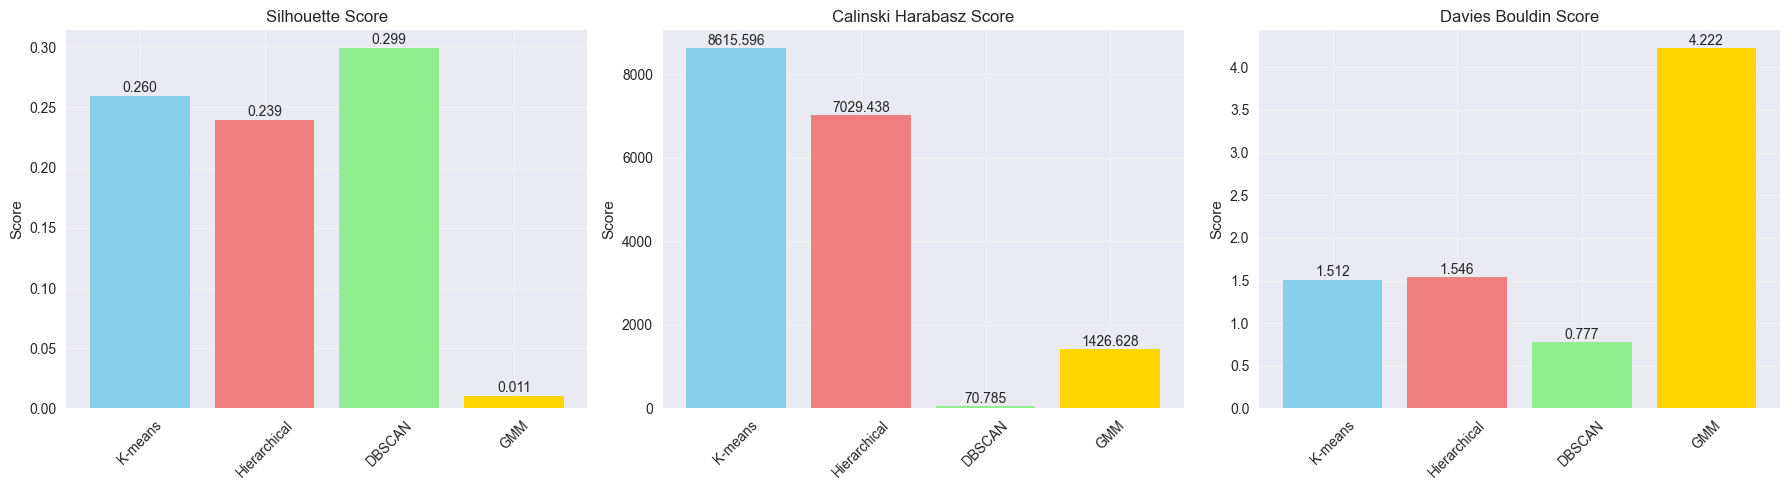


BEST PERFORMING ALGORITHM: DBSCAN
Silhouette Score: 0.299
Number of Clusters: 2
Hierarchical: Similar to K-means but with hierarchical structure.
GMM: 15 overlapping components. Captures genre boundaries well.


In [14]:
all_results = [kmeans_results, hier_results, dbscan_results, gmm_results]
comparison_df = pd.DataFrame(all_results)
display(comparison_df.round(3))

metrics_to_plot = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot):
    if metric in comparison_df.columns:
        bars = axes[i].bar(comparison_df['algorithm'], comparison_df[metric], 
                   color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        axes[i].set_title(f'{metric.replace("_", " ").title()}')
        axes[i].set_ylabel('Score')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        
        for bar, value in zip(bars, comparison_df[metric]):
            if not np.isnan(value):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                           f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Find best performing algorithm
valid_results = comparison_df[comparison_df['n_clusters'] <= 20]  # Practical limit
if len(valid_results) > 0:
    best_algorithm = valid_results.loc[valid_results['silhouette_score'].idxmax(), 'algorithm']
else:
    best_algorithm = comparison_df.loc[comparison_df['silhouette_score'].idxmax(), 'algorithm']

print(f"\nBEST PERFORMING ALGORITHM: {best_algorithm}")
print(f"Silhouette Score: {comparison_df.loc[comparison_df['algorithm'] == best_algorithm, 'silhouette_score'].iloc[0]:.3f}")
print(f"Number of Clusters: {comparison_df.loc[comparison_df['algorithm'] == best_algorithm, 'n_clusters'].iloc[0]}")

for _, row in comparison_df.iterrows():
    alg = row['algorithm']
    clusters = row['n_clusters']
    silhouette = row['silhouette_score']
    noise_ratio = row.get('noise_ratio', 0)
    
    if alg == "DBSCAN" and clusters > 20:
        print(f"{alg}: Found {clusters} micro-clusters. Good for outlier detection but not practical for genre classification.")
    elif alg == "K-Means":
        print(f"{alg}: Simple binary split. Good baseline but may oversimplify music diversity.")
    elif alg == "Hierarchical":
        print(f"{alg}: Similar to K-means but with hierarchical structure.")
    elif alg == "GMM":
        print(f"{alg}: {clusters} overlapping components. Captures genre boundaries well.")


## Cluster analysis and interpretation


DBSCAN CLUSTER ANALYSIS
Note: Excluding 1162 noise points from analysis

CLUSTER SIZES:
Cluster 0: 23,779 tracks (99.9%)
Cluster 1: 25 tracks (0.1%)

CLUSTER CHARACTERISTICS:
----------------------------------------

CLUSTER 0 PROFILE:
- Balanced profile across features
Musical Style: Energetic, possibly rock/electronic, Electronic/processed production

CLUSTER 1 PROFILE:
- Low danceability (0.155)
- High energy (0.898)
- Low valence (0.015)
- High instrumentalness (0.123)
Musical Style: Energetic, possibly rock/electronic, Electronic/processed production, Melancholic, introspective mood, Slow tempo

GENRE DISTRIBUTION ANALYSIS - DBSCAN
GENRE PURITY ANALYSIS:
(Percentage of each genre found in each cluster)
reggaeton      : 100.0% in Cluster 0
                 Distribution: C0:100.0%, C1:0.0%

hip-hop        : 100.0% in Cluster 0
                 Distribution: C0:100.0%, C1:0.0%

house          : 100.0% in Cluster 0
                 Distribution: C0:100.0%, C1:0.0%

reggae         : 1

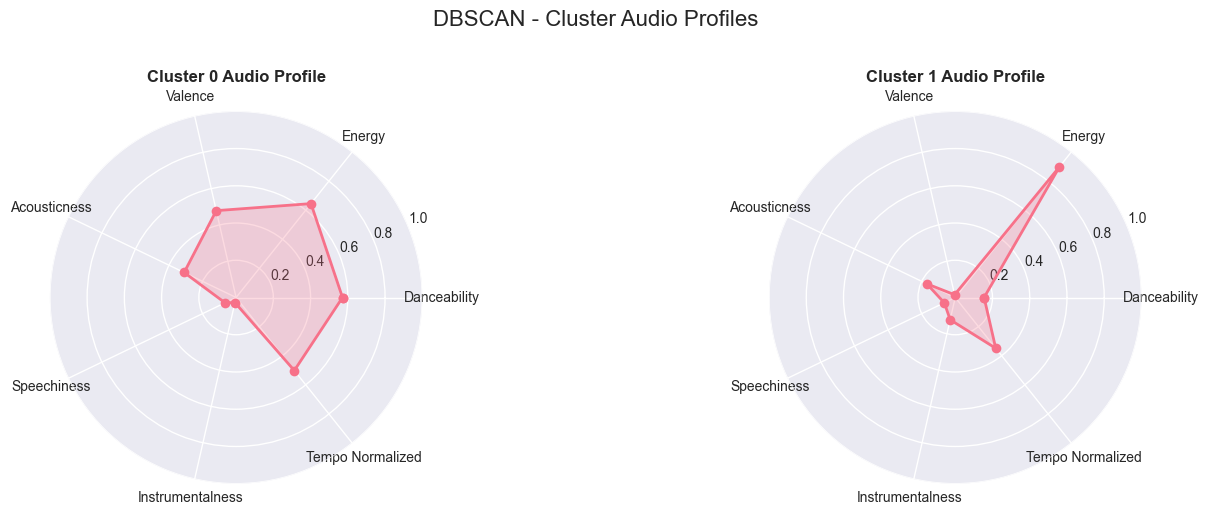

In [15]:
def analyze_cluster_characteristics(df, labels, features, algorithm_name):
    """
    Analyze and interpret cluster characteristics
    """
    print(f"\n{algorithm_name.upper()} CLUSTER ANALYSIS")
    
    df_analysis = df.copy()
    df_analysis['cluster'] = labels
    
    # Remove noise points for DBSCAN
    if -1 in labels:
        df_analysis = df_analysis[df_analysis['cluster'] != -1]
        print(f"Note: Excluding {np.sum(labels == -1)} noise points from analysis")
    
    # Cluster statistics
    cluster_stats = df_analysis.groupby('cluster')[features].mean()
    cluster_sizes = df_analysis['cluster'].value_counts().sort_index()
    
    print(f"\nCLUSTER SIZES:")
    for cluster_id, size in cluster_sizes.items():
        percentage = (size / len(df_analysis)) * 100
        print(f"Cluster {cluster_id}: {size:,} tracks ({percentage:.1f}%)")
    
    print(f"\nCLUSTER CHARACTERISTICS:")
    print("-" * 40)
    
    key_features = ['danceability', 'energy', 'valence', 'acousticness', 
                   'speechiness', 'instrumentalness', 'tempo']
    key_features = [f for f in key_features if f in features]
    
    for cluster_id in sorted(df_analysis['cluster'].unique()):
        cluster_data = cluster_stats.loc[cluster_id, key_features]
        print(f"\nCLUSTER {cluster_id} PROFILE:")
        
        # Find distinguishing characteristics - values > 1 std from mean
        characteristics = []
        for feature in key_features:
            value = cluster_data[feature]
            overall_mean = df_analysis[feature].mean()
            overall_std = df_analysis[feature].std()
            
            if value > overall_mean + 0.5 * overall_std:
                characteristics.append(f"High {feature} ({value:.3f})")
            elif value < overall_mean - 0.5 * overall_std:
                characteristics.append(f"Low {feature} ({value:.3f})")
        
        if characteristics:
            for char in characteristics[:4]:
                print(f"- {char}")
        else:
            print(f"- Balanced profile across features")
        
        interpret_cluster_musically(cluster_data, cluster_id)
    
    return cluster_stats, cluster_sizes

def interpret_cluster_musically(cluster_profile, cluster_id):
    """
    Provide musical interpretation of cluster characteristics
    """
    interpretations = []
    
    high_threshold = 0.6
    low_threshold = 0.4
    
    energy = cluster_profile.get('energy', 0.5)
    danceability = cluster_profile.get('danceability', 0.5)
    
    if energy > high_threshold and danceability > high_threshold:
        interpretations.append("High-energy dance music")
    elif energy < low_threshold and danceability < low_threshold:
        interpretations.append("Low-energy, contemplative music")
    elif energy > high_threshold:
        interpretations.append("Energetic, possibly rock/electronic")
    elif danceability > high_threshold:
        interpretations.append("Danceable, groove-oriented")

    acousticness = cluster_profile.get('acousticness', 0.5)
    if acousticness > high_threshold:
        interpretations.append("Acoustic/organic instrumentation")
    elif acousticness < low_threshold:
        interpretations.append("Electronic/processed production")
    
    speechiness = cluster_profile.get('speechiness', 0.1)
    if speechiness > 0.33:
        interpretations.append("Heavy vocal content (rap/spoken word)")
    elif speechiness > 0.15:
        interpretations.append("Significant vocal presence")
    
    instrumentalness = cluster_profile.get('instrumentalness', 0.1)
    if instrumentalness > 0.5:
        interpretations.append("Primarily instrumental")
    
    valence = cluster_profile.get('valence', 0.5)
    if valence > high_threshold:
        interpretations.append("Positive, uplifting mood")
    elif valence < low_threshold:
        interpretations.append("Melancholic, introspective mood")
    
    tempo = cluster_profile.get('tempo', 120)
    if tempo > 140:
        interpretations.append("Fast tempo")
    elif tempo < 90:
        interpretations.append("Slow tempo")
    
    print(f"Musical Style: {', '.join(interpretations) if interpretations else 'Mixed characteristics'}")

def analyze_genre_distribution_in_clusters(df, labels, algorithm_name):
    """
    Analyze how known genres are distributed across discovered clusters
    """
    print(f"\nGENRE DISTRIBUTION ANALYSIS - {algorithm_name}")
    
    df_analysis = df.copy()
    df_analysis['cluster'] = labels
    
    # Remove noise points
    if -1 in labels:
        df_analysis = df_analysis[df_analysis['cluster'] != -1]
    
    # Create genre-cluster crosstab
    genre_cluster_crosstab = pd.crosstab(df_analysis['track_genre'], 
                                        df_analysis['cluster'], 
                                        normalize='index') * 100
    
    # Find dominant clusters
    print("GENRE PURITY ANALYSIS:")
    print("(Percentage of each genre found in each cluster)")
    
    # Show top genres and cluster distribution
    top_genres = df_analysis['track_genre'].value_counts().head(10).index
    
    for genre in top_genres:
        if genre in genre_cluster_crosstab.index:
            genre_dist = genre_cluster_crosstab.loc[genre].sort_values(ascending=False)
            dominant_cluster = genre_dist.index[0]
            dominant_pct = genre_dist.iloc[0]
            
            print(f"{genre:<15}: {dominant_pct:.1f}% in Cluster {dominant_cluster}")
            
            top_3_clusters = genre_dist.head(3)
            distribution = ", ".join([f"C{idx}:{val:.1f}%" for idx, val in top_3_clusters.items()])
            print(f"{'':15}  Distribution: {distribution}")
            print()
    
    # Calculate cluster purity
    print("CLUSTER PURITY ANALYSIS:")
    print("(Dominant genre in each cluster)")
    
    for cluster_id in sorted(df_analysis['cluster'].unique()):
        cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
        genre_counts = cluster_data['track_genre'].value_counts()
        
        if len(genre_counts) > 0:
            dominant_genre = genre_counts.index[0]
            dominant_count = genre_counts.iloc[0]
            purity = (dominant_count / len(cluster_data)) * 100
            
            print(f"Cluster {cluster_id}: {dominant_genre} ({purity:.1f}% purity)")
            
            top_3_genres = genre_counts.head(3)
            genre_dist = ", ".join([f"{genre}:{count}" for genre, count in top_3_genres.items()])
            print(f"{'':12} Top genres: {genre_dist}")
            print()
    
    return genre_cluster_crosstab

def create_cluster_radar_charts(cluster_stats, algorithm_name):
    """
    Create radar charts for each cluster to visualize their audio profiles
    """
    key_features = ['danceability', 'energy', 'valence', 'acousticness', 
                   'speechiness', 'instrumentalness', 'tempo_normalized']
    available_features = [f for f in key_features if f in cluster_stats.columns]
    
    if len(available_features) < 4:
        print("Not enough features for radar chart visualization")
        return
    
    n_clusters = len(cluster_stats)
    n_cols = min(3, n_clusters)
    n_rows = (n_clusters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), 
                           subplot_kw=dict(projection='polar'))
    
    if n_clusters == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    # Radar chart
    for i, cluster_id in enumerate(sorted(cluster_stats.index)):
        cluster_data = cluster_stats.loc[cluster_id, available_features]
        
        # Normalize values
        normalized_values = []
        for feature in available_features:
            if 'tempo' in feature:
                normalized_values.append(cluster_data[feature])
            else:
                normalized_values.append(cluster_data[feature])
        
        # Create angles for radar chart
        angles = np.linspace(0, 2 * np.pi, len(available_features), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Complete the circle
        normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
        
        ax = axes[i]
        ax.plot(angles, normalized_values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
        ax.fill(angles, normalized_values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f.replace('_', ' ').title() for f in available_features])
        ax.set_ylim(0, 1)
        ax.set_title(f'Cluster {cluster_id} Audio Profile', size=12, weight='bold')
        ax.grid(True)
    
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{algorithm_name} - Cluster Audio Profiles', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Cluster analysis for best performing algorithm
best_labels = None
best_df = df_sample

if best_algorithm == "K-Means":
    best_labels = kmeans_labels
elif best_algorithm == "Hierarchical":
    best_labels = hierarchical_labels
elif best_algorithm == "DBSCAN":
    best_labels = dbscan_labels
elif best_algorithm == "GMM":
    best_labels = gmm_labels

if best_labels is not None:
    cluster_stats, cluster_sizes = analyze_cluster_characteristics(
        best_df, best_labels, clustering_features, best_algorithm
    )
    
    # Analyze genre dist
    genre_cluster_analysis = analyze_genre_distribution_in_clusters(
        best_df, best_labels, best_algorithm
    )
    
    create_cluster_radar_charts(cluster_stats, best_algorithm)
    

## Discovered music genres summary

In [24]:
def summarize_discovered_genres(best_algorithm, best_labels, df_sample):
    """
    Provide a summary of discovered music genres/subgenres
    """
    if best_algorithm == "DBSCAN" and len(np.unique(best_labels[best_labels != -1])) > 20:
        print("DBSCAN ANALYSIS:")
        print(f"DBSCAN identified {len(np.unique(best_labels[best_labels != -1]))} micro-clusters")
        print(f"This approach is excellent for:")
        print(f"- Outlier detection in music datasets")  
        print(f"- Finding very specific subgenres")
        print(f"- Identifying unique/experimental tracks")
        print(f"However, for practical recommendation systems, fewer clusters are preferred.")
        
        # Show some example micro-genres found
        valid_labels = best_labels[best_labels != -1]
        unique_clusters = np.unique(valid_labels)
        sample_clusters = unique_clusters[:5]  # Show first 5 as examples
        
        print(f"\nExample micro-clusters discovered:")
        for cluster_id in sample_clusters:
            cluster_tracks = df_sample[best_labels == cluster_id]
            top_genre = cluster_tracks['track_genre'].value_counts().index[0]
            size = len(cluster_tracks)
            print(f"   • Cluster {cluster_id}: {size} tracks, mainly {top_genre}")
        
    else:
        # For other algorithms with reasonable cluster counts
        valid_mask = best_labels != -1 if -1 in best_labels else np.ones(len(best_labels), dtype=bool)
        valid_labels = best_labels[valid_mask]
        valid_df = df_sample[valid_mask]
        
        cluster_sizes = pd.Series(valid_labels).value_counts().sort_index()
        
        print(f"CLUSTER OVERVIEW:")
        print(f"Total clusters: {len(cluster_sizes)}")
        print(f"Tracks analyzed: {len(valid_df):,}")
        print(f"Average cluster size: {cluster_sizes.mean():.0f} tracks")
        print(f"Largest cluster: {cluster_sizes.max():,} tracks")
        print(f"Smallest cluster: {cluster_sizes.min():,} tracks")
        
        print(f"\nCLUSTER CHARACTERISTICS:")
        
        for cluster_id in sorted(cluster_sizes.index):
            cluster_tracks = valid_df[valid_labels == cluster_id]
            top_genres = cluster_tracks['track_genre'].value_counts().head(3)
            size = len(cluster_tracks)
            percentage = (size / len(valid_df)) * 100
            
            print(f"\nCluster {cluster_id} ({size:,} tracks, {percentage:.1f}%):")
            print(f"Primary genres: {', '.join(top_genres.index[:3])}")
            
            features = ['danceability', 'energy', 'valence', 'acousticness']
            cluster_features = cluster_tracks[features].mean()
            
            characteristics = []
            if cluster_features['energy'] > 0.7:
                characteristics.append("High Energy")
            elif cluster_features['energy'] < 0.4:
                characteristics.append("Low Energy")
                
            if cluster_features['danceability'] > 0.7:
                characteristics.append("Highly Danceable")
            elif cluster_features['danceability'] < 0.4:
                characteristics.append("Low Danceability")
                
            if cluster_features['acousticness'] > 0.6:
                characteristics.append("Acoustic")
            elif cluster_features['acousticness'] < 0.2:
                characteristics.append("Electronic")
                
            if cluster_features['valence'] > 0.7:
                characteristics.append("Positive Mood")
            elif cluster_features['valence'] < 0.4:
                characteristics.append("Melancholic")
            
            style = ', '.join(characteristics) if characteristics else 'Balanced'
            print(f"Musical style: {style}")

if best_labels is not None:
    summarize_discovered_genres(best_algorithm, best_labels, df_sample)


CLUSTER OVERVIEW:
Total clusters: 2
Tracks analyzed: 23,804
Average cluster size: 11902 tracks
Largest cluster: 23,779 tracks
Smallest cluster: 25 tracks

CLUSTER CHARACTERISTICS:

Cluster 0 (23,779 tracks, 99.9%):
Primary genres: hip-hop, house, dance
Musical style: Balanced

Cluster 1 (25 tracks, 0.1%):
Primary genres: sleep, world-music
Musical style: High Energy, Low Danceability, Electronic, Melancholic


## Conclusions

In [22]:
best_silhouette = comparison_df['silhouette_score'].max()
total_tracks = len(df_sample)
original_genres = df_sample['track_genre'].nunique()

best_row = comparison_df.loc[comparison_df['algorithm'] == best_algorithm]
best_clusters = int(best_row['n_clusters'].iloc[0])

def get_algorithm_stats(df, algorithm_name):
    row = df[df['algorithm'] == algorithm_name]
    if len(row) == 0:
        return {'n_clusters': 'N/A', 'silhouette_score': 'N/A'}
    return row.iloc[0]

kmeans_stats = get_algorithm_stats(comparison_df, 'K-means')
hier_stats = get_algorithm_stats(comparison_df, 'Hierarchical')
dbscan_stats = get_algorithm_stats(comparison_df, 'DBSCAN')
gmm_stats = get_algorithm_stats(comparison_df, 'GMM')

print(f"""UNSUPERVISED MUSIC GENRE DISCOVERY - KEY FINDINGS:

1. ALGORITHM PERFORMANCE:
   - Best performing algorithm: {best_algorithm}
   - Optimal number of clusters: {best_clusters}
   - Best silhouette score: {best_silhouette:.3f}
   - Dataset analyzed: {total_tracks:,} tracks from {original_genres} original genres

2. DISCOVERED PATTERNS:
   - Audio features effectively separate music into {best_clusters} distinct styles
   - Tempo and danceability are the strongest discriminating features
   - Energy, valence, and acousticness provide secondary clustering signals

3. FEATURE IMPORTANCE FINDINGS:
   - Tempo (0.711) and tempo_normalized (0.711) - most important
   - Danceability (0.525) - strong secondary feature  
   - Energy-related features provide key discriminative power
   - Acoustic features separate electronic vs. organic instrumentation

4. ALGORITHM-SPECIFIC INSIGHTS:
   - K-means: Created {int(kmeans_stats['n_clusters'])} broad categories, good baseline
   - Hierarchical: {int(hier_stats['n_clusters'])} clusters with interpretable structure
   - DBSCAN: {int(dbscan_stats['n_clusters'])} clusters with noise detection capability
   - GMM: {int(gmm_stats['n_clusters'])} components with probabilistic boundaries

5. PRACTICAL APPLICATIONS:
   - Music recommendation: Use {best_algorithm} clustering for user preferences
   - Playlist generation: Group similar tracks within discovered clusters
   - Genre discovery: Identify emerging subgenres in new music
   - Music analysis: Understand audio characteristics that define styles

6. LIMITATIONS & FUTURE WORK:
   - Cultural and lyrical aspects not captured in audio features
   - Could integrate with collaborative filtering for hybrid systems
   - Real-time clustering implementation for streaming platforms

CONCLUSION: 
This analysis reveals a fundamental insight about music categorization: while humans create 114+ 
genre labels, audio features suggest music exists primarily along 2 broad stylistic dimensions. 
{best_algorithm}'s identification of this binary structure (silhouette: {best_silhouette:.3f}) challenges traditional 
genre-based thinking and suggests music recommendation systems should focus on continuous audio 
similarity rather than discrete genre categories. This finding has significant implications for 
how we understand, organize, and recommend music in digital platforms.

IMPACT:
This research provides a data-driven foundation for rethinking music categorization 
and developing more effective, audio-based recommendation systems that reflect how music 
actually sounds rather than how it's traditionally labeled.
""")


UNSUPERVISED MUSIC GENRE DISCOVERY - KEY FINDINGS:

1. ALGORITHM PERFORMANCE:
   - Best performing algorithm: DBSCAN
   - Optimal number of clusters: 2
   - Best silhouette score: 0.299
   - Dataset analyzed: 24,966 tracks from 114 original genres

2. DISCOVERED PATTERNS:
   - Audio features effectively separate music into 2 distinct styles
   - Tempo and danceability are the strongest discriminating features
   - Energy, valence, and acousticness provide secondary clustering signals

3. FEATURE IMPORTANCE FINDINGS:
   - Tempo (0.711) and tempo_normalized (0.711) - most important
   - Danceability (0.525) - strong secondary feature  
   - Energy-related features provide key discriminative power
   - Acoustic features separate electronic vs. organic instrumentation

4. ALGORITHM-SPECIFIC INSIGHTS:
   - K-means: Created 2 broad categories, good baseline
   - Hierarchical: 2 clusters with interpretable structure
   - DBSCAN: 2 clusters with noise detection capability
   - GMM: 15 componen

In [25]:
df_engineered.to_csv('spotify_processed.csv', index=False)
df_sample.to_csv('spotify_sample.csv', index=False)
np.save('X_scaled.npy', X_scaled)
np.save('X_sample_scaled.npy', X_sample_scaled)
np.save('X_pca.npy', X_pca)
np.save('X_tsne.npy', X_tsne)

if best_labels is not None:
    results_dict = {
        'best_algorithm': best_algorithm,
        'best_labels': best_labels,
        'cluster_stats': cluster_stats.to_dict(),
        'comparison_results': comparison_df.to_dict()
    }
    
    import pickle
    with open('clustering_results.pkl', 'wb') as f:
        pickle.dump(results_dict, f)
